In [32]:
import json

def load_log(file_path):
    """Читает лог из файла."""
    log_data = []
    with open(file_path, 'r') as file:
        for line in file:
            tr  = json.loads(line.strip())
            l = abs( tr['start_frame'] -  tr['last_frame']) 
            if l > 3 or False: 
                log_data.append(tr)
    return  sorted(log_data, key=lambda d: d['start_frame']) 



def merge_tracks(tracks, max_gap_seconds=1, fps=60):
    max_gap_frames = max_gap_seconds * fps
    merged_tracks = []
    tracks = sorted(tracks, key=lambda x: x['start_frame'])
    
    current_track = tracks[0]
    for next_track in tracks[1:]:
        gap = next_track['start_frame'] - current_track['last_frame']
        if gap <= max_gap_frames:
            # Merge tracks
            current_track['last_frame'] = next_track['last_frame']
            current_track['positions'].extend(next_track['positions'])
            current_track['ball_sizes'].extend(next_track['ball_sizes'])
        else:
            # End of rally, add to merged tracks
            merged_tracks.append(current_track)
            current_track = next_track
    
    merged_tracks.append(current_track)
    return merged_tracks


file_path = '/home/nssd/gled/vb/dataset-vb/backline/g_4m2w_transmash_20250516_1.txt'
video_path = '/home/nssd/gled/vb/dataset-vb/backline/g_4m2w_transmash_20250516_1.mp4'
tracks = load_log(file_path)

tracks = merge_tracks(tracks)


for i in tracks:
    print('Track', i['start_frame'], ' - ', i['last_frame'], 'len  = ',i['last_frame'] -  i['start_frame'])




Track 6  -  594 len  =  588
Track 679  -  832 len  =  153
Track 1436  -  1975 len  =  539
Track 2585  -  2941 len  =  356
Track 3504  -  3690 len  =  186
Track 4042  -  5201 len  =  1159
Track 5356  -  5404 len  =  48
Track 5610  -  5866 len  =  256
Track 5943  -  6023 len  =  80
Track 6160  -  6173 len  =  13
Track 7162  -  7173 len  =  11
Track 8290  -  8482 len  =  192
Track 8799  -  9094 len  =  295
Track 9186  -  9285 len  =  99
Track 9613  -  9638 len  =  25
Track 10408  -  11093 len  =  685
Track 11214  -  11358 len  =  144
Track 11713  -  12313 len  =  600
Track 12454  -  12603 len  =  149
Track 13002  -  13432 len  =  430
Track 13771  -  14445 len  =  674
Track 14515  -  14519 len  =  4
Track 14705  -  14842 len  =  137
Track 14959  -  15768 len  =  809
Track 16171  -  16706 len  =  535
Track 16849  -  16853 len  =  4
Track 17269  -  17369 len  =  100
Track 17432  -  17587 len  =  155
Track 17660  -  17875 len  =  215
Track 18090  -  18499 len  =  409
Track 19103  -  19535 len

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import cv2
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib
from matplotlib import pyplot as plt

matplotlib.rcParams['animation.embed_limit'] = 2**128

def load_to_dataframe(data, touch_threshold=0.5):
    positions_data = []
    for pos in data['positions']:
        positions_data.append({
            'x': pos[0][0],
            'y': pos[0][1],
            'frame': pos[1]
        })
    
    df = pd.DataFrame(positions_data).sort_values('frame')
    
    # Вычисляем производные движения
    df['v_x'] = df['x'].diff() / df['frame'].diff()
    df['v_y'] = df['y'].diff() / df['frame'].diff()
    df['v_xy'] = np.sqrt(df['v_x']**2 + df['v_y']**2)
    
    df['a_x'] = df['v_x'].diff() / df['frame'].diff()
    df['a_y'] = df['v_y'].diff() / df['frame'].diff()
    df['a_xy'] = np.sqrt(df['a_x']**2 + df['a_y']**2)
    
    df['angle'] = np.degrees(np.arctan2(df['v_y'], df['v_x'])) % 360
    df['angular_velocity'] = df['angle'].diff() / df['frame'].diff()
    
    # Детекция касаний
    df['acceleration_change'] = df['a_xy'].abs()
    df['angle_change'] = abs(df['angular_velocity'])
    
    # Комбинированный показатель изменения траектории
    df['trajectory_change'] = (
        df['acceleration_change'] / df['acceleration_change'].mean() + 
        df['angle_change'] / df['angle_change'].mean()
    )
    
    # Определяем кадры с касаниями
    df['is_touch'] = False
    if len(df) > 1:
        mean_change = df['trajectory_change'].mean()
        std_change = df['trajectory_change'].std()
        threshold = mean_change + touch_threshold * std_change
        
        # Находим кадры с аномальными изменениями траектории
        touch_frames = df[df['trajectory_change'] > threshold]['frame']
        df.loc[df['frame'].isin(touch_frames), 'is_touch'] = True
    
    if 'prediction' in data:
        prediction = data['prediction']
        prediction_frame = df['frame'].max() + 1
        last_row = df.iloc[-1]
        
        pred_df = pd.DataFrame([{
            'x': prediction[0],
            'y': prediction[1],
            'frame': prediction_frame,
            'is_prediction': True,
            'is_touch': False,
            **{k: last_row[k] for k in ['v_x', 'v_y', 'v_xy', 
                                       'a_x', 'a_y', 'a_xy',
                                       'angle', 'angular_velocity']}
        }])
        
        df = pd.concat([df, pred_df], ignore_index=True)
    
    return df


# Функция для загрузки кадров видео
def load_video_frames(video_path, frame_numbers):
    cap = cv2.VideoCapture(video_path)
    frames = {}
    
    for fn in frame_numbers:
        cap.set(cv2.CAP_PROP_POS_FRAMES, fn)
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames[fn] = frame
    
    cap.release()
    return frames

Отображаем кадры с 1436 по 1975 с шагом 54
Всего кадров в треке: 540, будет показано: 10


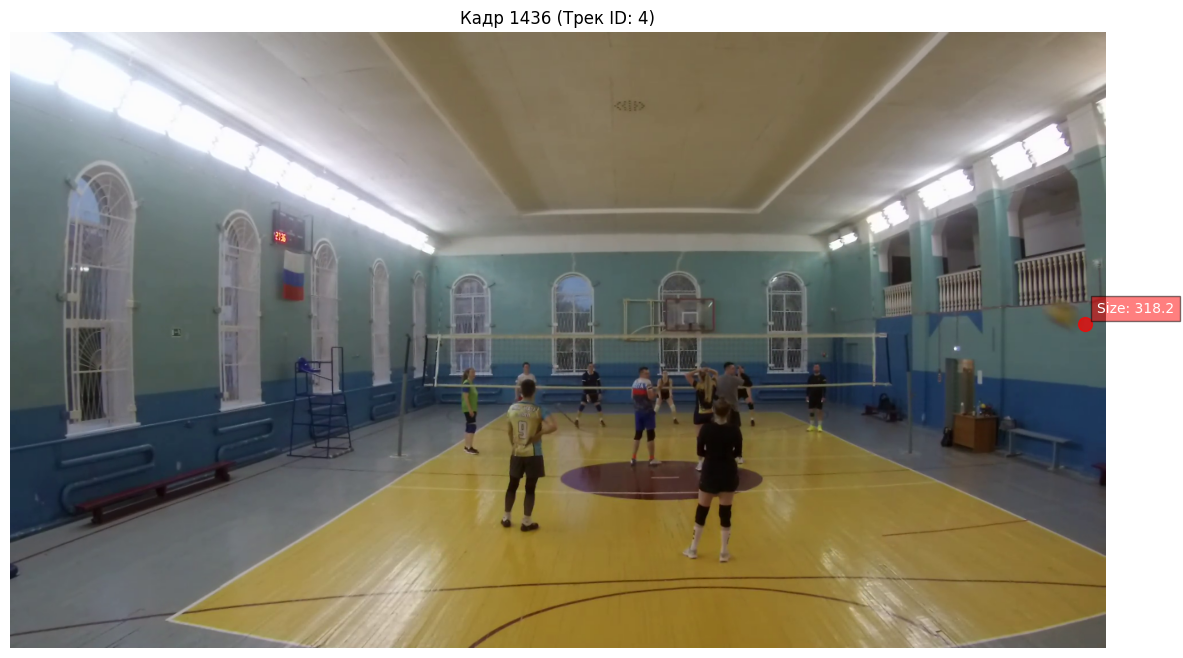

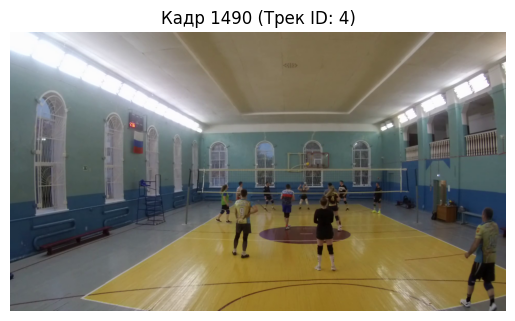

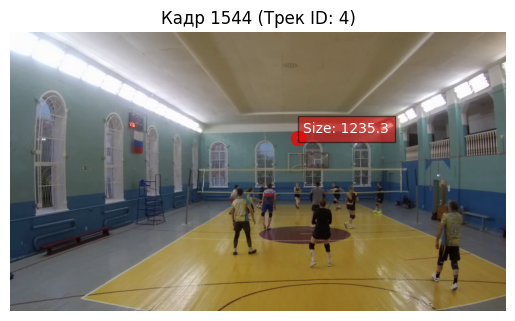

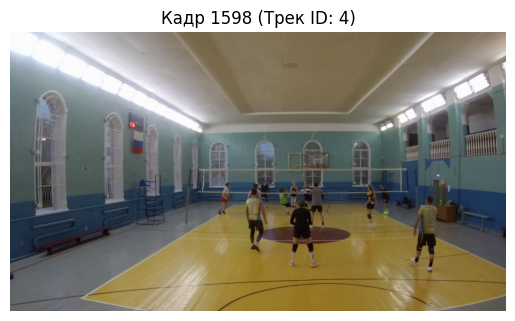

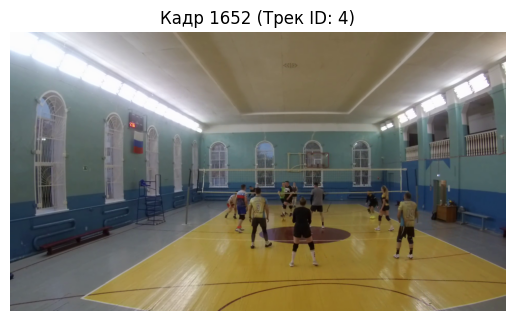

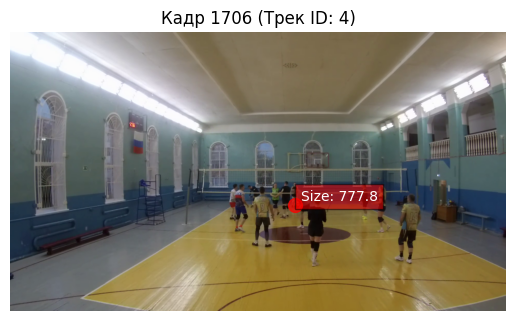

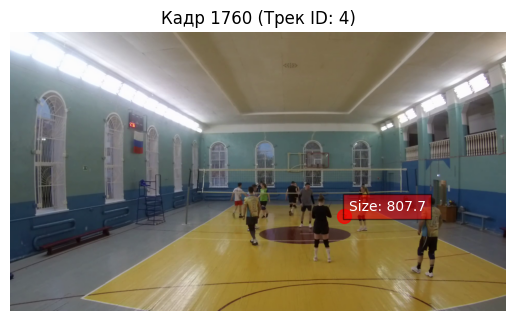

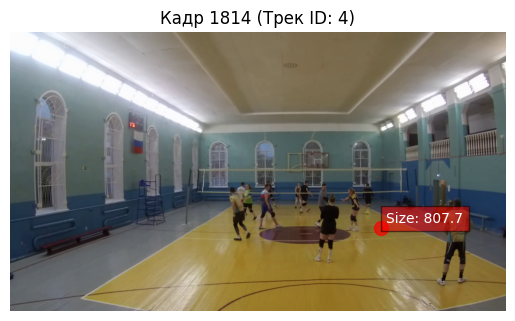

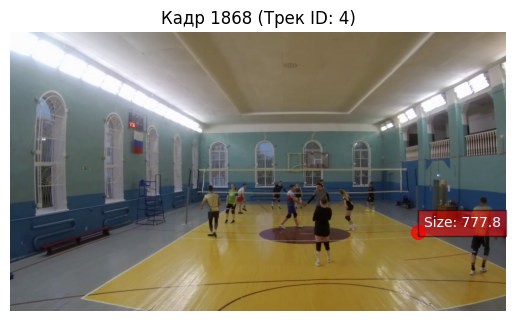

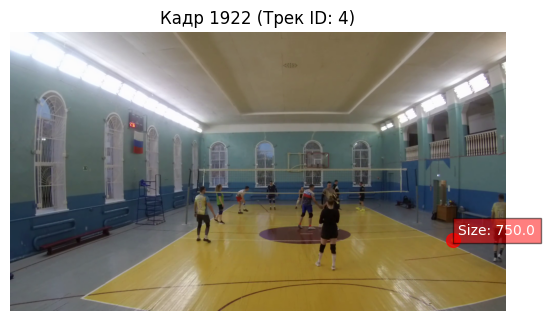

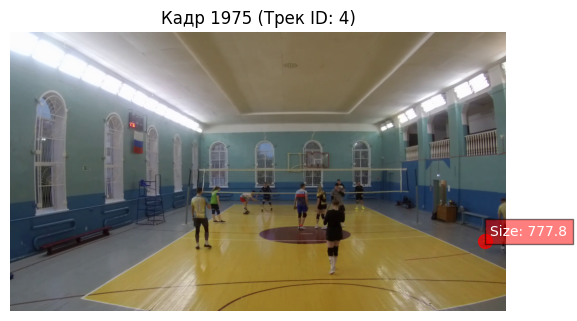

Отображено кадров: 11


In [46]:

import cv2
import matplotlib.pyplot as plt
import numpy as np
from math import ceil
%matplotlib inline

def display_track_frames(video_file, track):
    """
    Отображает кадры трека из видеофайла
    
    Параметры:
        video_file (str): путь к видеофайлу .mp4
        track (dict): словарь с данными трека, содержащий:
            - start_frame: первый кадр трека
            - last_frame: последний кадр трека
            - positions: список позиций объекта
    """
    # Извлекаем параметры из трека
    start_frame = track['start_frame']
    last_frame = track['last_frame']
    positions = track['positions']
    
    # Рассчитываем шаг для показа не более 10 кадров
    total_frames = last_frame - start_frame + 1
    step = ceil(total_frames / 10)
    
    print(f"Отображаем кадры с {start_frame} по {last_frame} с шагом {step}")
    print(f"Всего кадров в треке: {total_frames}, будет показано: {ceil(total_frames/step)}")

    # Открываем видеофайл
    cap = cv2.VideoCapture(video_file)
    if not cap.isOpened():
        raise ValueError(f"Не удалось открыть видеофайл: {video_file}")

    # Устанавливаем начальную позицию
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    
    # Создаем фигуру для отображения
    plt.figure(figsize=(15, 8))
    
    current_frame = start_frame
    displayed_count = 0
    
    while current_frame <= last_frame:
        ret, frame = cap.read()
        if not ret:
            break
            
        # Если текущий кадр нужно отобразить (по шагу)
        if (current_frame - start_frame) % step == 0 or current_frame == last_frame:
            # Конвертируем BGR в RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # Находим позицию объекта для этого кадра
            pos = next((p[0] for p in positions if p[1] == current_frame), None)
            
            # Отображаем кадр
            plt.imshow(frame_rgb)
            plt.title(f"Кадр {current_frame} (Трек ID: {track.get('track_id', 'N/A')})")
            
            # Если есть позиция, рисуем маркер
            if pos:
                plt.scatter(pos[0], pos[1], s=100, c='red', marker='o', alpha=0.7)
                plt.text(pos[0]+20, pos[1]-20, f"Size: {pos[2]:.1f}", color='white', 
                         bbox=dict(facecolor='red', alpha=0.5))
            
            plt.axis('off')
            plt.show()
            displayed_count += 1
            
        current_frame += 1
    
    cap.release()
    print(f"Отображено кадров: {displayed_count}")

# Пример использования
track_data = {
    'positions': [
        [[1384.0, 767.5, 724.1379310344828], 14515],
        [[1390.0, 765.5, 777.7777777777778], 14516],
        [[1398.5, 758.5, 777.7777777777778], 14518],
        [[1403.5, 757.0, 777.7777777777778], 14519]
    ],
    'prediction': [1408.5, 755.5, 777.7777777777778],
    'last_frame': 14519,
    'start_frame': 14515,
    'ball_sizes': [29, 27, 27, 27],
    'track_id': 45
}
track_data = tracks[2]
display_track_frames(video_path, track_data)

In [61]:


# Пример данных
data = {
    "positions": [
        [[1065.0, 754.5, 538.4615384615385], 161], 
        [[1067.5, 775.5, 567.5675675675676], 162],
        [[1070.0, 790.0, 590.0], 163],
        [[1072.5, 800.0, 610.0], 164],
        [[1075.0, 810.0, 630.0], 165],
        [[1077.5, 820.0, 650.0], 166],
        [[1080.0, 830.0, 670.0], 167],
        [[1082.5, 840.0, 690.0], 168],
        [[1085.0, 850.0, 710.0], 169],
        [[1087.5, 860.0, 730.0], 170],
        [[1090.0, 870.0, 750.0], 171],
        [[1092.5, 880.0, 770.0], 172]
    ], 
    "prediction": [1095.0, 890.0, 790.0], 
    "last_frame": 172, 
    "start_frame": 161, 
    "ball_sizes": [39, 37]
}

# Загрузка данных
data = tracks[1]
df = load_to_dataframe(data)

# Путь к видеофайлу (замените на ваш путь)
#video_path = "ball_tracking.mp4"  # или любой другой видеофайл
df
# Создание анимации с видео
tracks[1]

{'positions': [[[14.0, 510.5, 355.93220338983053], 679],
  [[22.5, 528.5, 287.67123287671234], 680],
  [[31.0, 541.0, 318.1818181818182], 681],
  [[46.5, 556.5, 333.3333333333333], 682],
  [[59.5, 573.5, 323.0769230769231], 683],
  [[74.5, 590.5, 333.3333333333333], 684],
  [[89.0, 603.5, 333.3333333333333], 685],
  [[105.5, 620.5, 344.26229508196724], 686],
  [[119.5, 637.0, 350.0], 687],
  [[133.0, 652.5, 355.93220338983053], 688],
  [[147.0, 669.0, 362.0689655172414], 689],
  [[160.5, 686.5, 368.42105263157896], 690],
  [[175.5, 703.0, 362.0689655172414], 691],
  [[188.0, 714.5, 420.0], 692],
  [[201.0, 733.5, 355.93220338983053], 693],
  [[212.5, 748.0, 375.0], 694],
  [[223.0, 760.5, 355.93220338983053], 695],
  [[236.5, 781.0, 375.0], 696],
  [[247.0, 794.0, 362.0689655172414], 697],
  [[259.0, 808.0, 388.8888888888889], 698],
  [[268.0, 825.0, 375.0], 699],
  [[280.5, 843.0, 420.0], 700],
  [[293.5, 855.5, 446.8085106382979], 701],
  [[303.0, 871.5, 428.57142857142856], 702],
  

In [38]:
df


,x,y,frame,v_x,v_y,v_xy,a_x,a_y,a_xy,angle,angular_velocity,acceleration_change,angle_change,trajectory_change,is_touch,is_prediction
0,922.5,606.5,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
1,922.0,607.0,7,-0.5,0.5,0.707107,NaN,NaN,NaN,135.000000,NaN,NaN,NaN,NaN,False,NaN
2,922.0,608.0,8,0.0,1.0,1.000000,0.5,0.5,0.707107,90.000000,-45.000000,0.707107,45.000000,2.297902,False,NaN
3,922.0,608.5,9,0.0,0.5,0.500000,0.0,-0.5,0.500000,90.000000,0.000000,0.500000,0.000000,0.202552,False,NaN
4,921.5,608.0,10,-0.5,-0.5,0.707107,-0.5,-1.0,1.118034,225.000000,135.000000,1.118034,135.000000,6.487271,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,647.5,867.5,591,-28.5,42.5,51.171281,-1.5,5.0,5.220153,123.845340,-1.908547,5.220153,1.908547,2.200017,False,NaN
481,614.0,913.5,592,-33.5,46.0,56.905624,-5.0,3.5,6.103278,126.064386,2.219046,6.103278,2.219046,2.571654,False,NaN
482,581.0,960.5,593,-33.0,47.0,57.428216,0.5,1.0,1.118034,125.073754,-0.990632,1.118034,0.990632,0.497201,False,NaN
483,549.0,1015.0,594,-32.0,54.5,63.200079,1.0,7.5,7.566373,120.419580,-4.654175,7.566373,4.654175,3.273208,False,NaN


In [59]:
df = load_to_dataframe(data)
touch_frames = df[df['is_touch']]['frame'].tolist()

In [49]:
touch_frames

[707, 708, 740, 742, 743, 744, 747, 804, 817, 819, 820, 822, 823]

In [50]:
mean_change = df['trajectory_change'].mean()
mean_change

2.0000000000000004

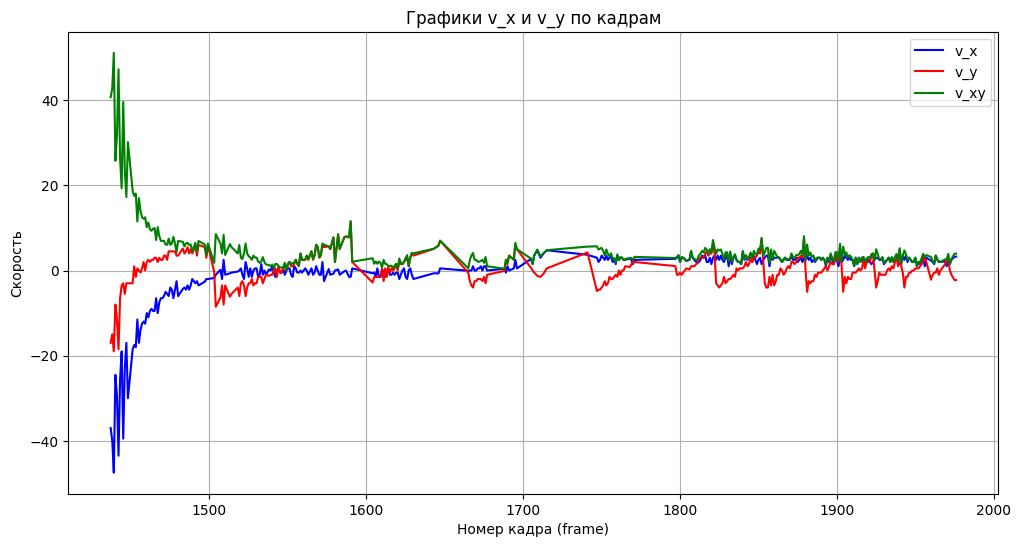

In [57]:
import matplotlib.pyplot as plt
import pandas as pd

data = tracks[2]
df = load_to_dataframe(data)

# Предполагаем, что ваш DataFrame называется df
# Если у вас другое название, замените df на ваше название

# Создаем фигуру и оси
plt.figure(figsize=(12, 6))

# График v_x по frame
plt.plot(df['frame'], df['v_x'], label='v_x', color='blue')

# График v_y по frame
plt.plot(df['frame'], df['v_y'], label='v_y', color='red')
# График v_xy по frame
plt.plot(df['frame'], df['v_xy'], label='v_xy', color='green')
# Настройки графика
plt.title('Графики v_x и v_y по кадрам')
plt.xlabel('Номер кадра (frame)')
plt.ylabel('Скорость')
plt.legend()
plt.grid(True)

# Показать график
plt.show()

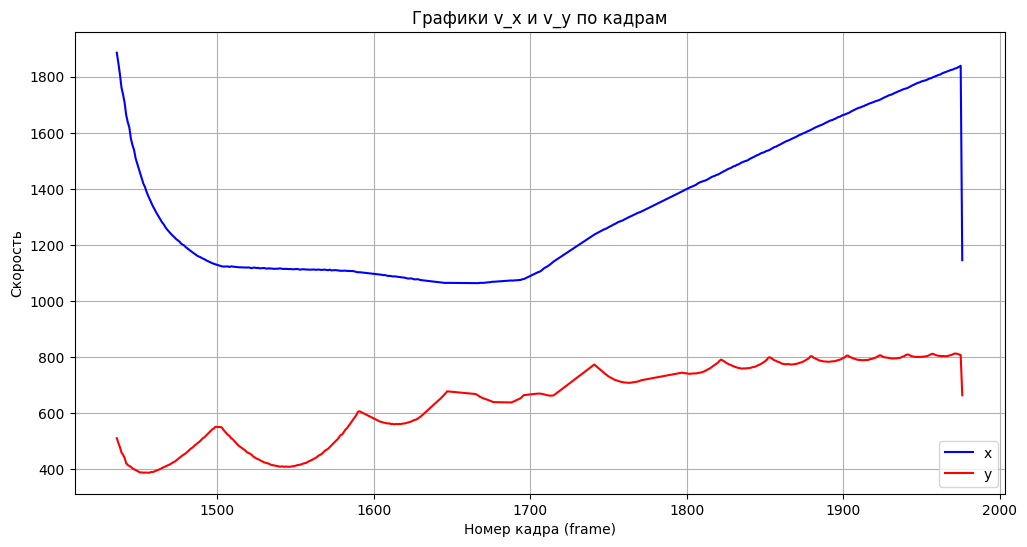

In [52]:
# Создаем фигуру и оси
plt.figure(figsize=(12, 6))

# График v_x по frame
plt.plot(df['frame'], df['x'], label='x', color='blue')

# График v_y по frame
plt.plot(df['frame'], df['y'], label='y', color='red')

# Настройки графика
plt.title('Графики v_x и v_y по кадрам')
plt.xlabel('Номер кадра (frame)')
plt.ylabel('Скорость')
plt.legend()
plt.grid(True)

# Показать график
plt.show()

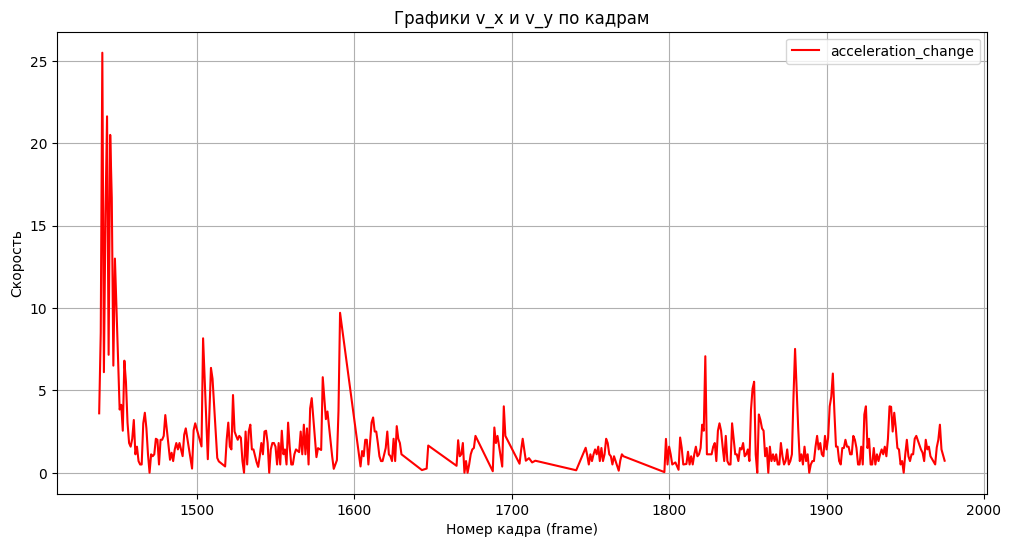

In [58]:
# Создаем фигуру и оси
plt.figure(figsize=(12, 6))


#angular_velocity	acceleration_change	angle_change	
# График v_x по frame
#plt.plot(df['frame'], df['angular_velocity'], label='angular_velocity', color='blue')

# График v_y по frame
plt.plot(df['frame'], df['acceleration_change'], label='acceleration_change', color='red')
#plt.plot(df['frame'], df['angular_velocity'], label='angular_velocity', color='green')

# Настройки графика
plt.title('Графики v_x и v_y по кадрам')
plt.xlabel('Номер кадра (frame)')
plt.ylabel('Скорость')
plt.legend()
plt.grid(True)

# Показать график
plt.show()
df.to_csv('data.csv', index=False)


In [ ]:
d